In [5]:
import os
import pandas as pd
import shutil

In [6]:
# prepare train

In [7]:
RAW_DATA_DIR = '../../data/raw_data/train'

IMAGES_TRAIN_DIR = '../../data/dataset/train/images'
MASKS_TRAIN_DIR = '../../data/dataset/train/masks'

# os.makedirs(IMAGES_TRAIN_DIR)
# os.makedirs(MASKS_TRAIN_DIR)

In [8]:
# ids
image_ids = os.listdir(RAW_DATA_DIR)

### Move data

In [11]:
# move dataset
for id in image_ids:
    
    src_image_path = os.path.join(RAW_DATA_DIR, id, id + '.png')
    src_mask_path = os.path.join(RAW_DATA_DIR, id, id + '_mask.png')
    
    dst_image_path = os.path.join(IMAGES_TRAIN_DIR, id + '.png')
    dst_mask_path = os.path.join(MASKS_TRAIN_DIR, id + '.png')
    
    shutil.copyfile(src_image_path, dst_image_path)
    shutil.copyfile(src_mask_path, dst_mask_path)                          

In [11]:
# constuct dataframe

dfs = []
for id in image_ids:
    
    _df = pd.read_csv(os.path.join(RAW_DATA_DIR, id, id + '.csv'), names=['ImageId', 'EncodedPixels'])
    
    dfs.append(_df)

In [12]:
all_df = pd.concat(dfs, ignore_index=True)

In [32]:
all_df.to_csv('../../data/dataset/train/masks.csv', index=False)

# folds 

In [39]:
folds = {
    'FOC': 0,
    'A14': 1,
    'E1Q': 1,
    'YTS': 2,
    'SQ7': 2,
    'AZ7': 0,
    'LJJ': 2,
    'T4Z': 0,
    '8B7': 2,
    'E60': 1,
}

In [40]:
out_data = []

for id in image_ids:
    out_data.append({
        'ImageId': id,
        'fold': folds.get(id[:3])
    })

In [42]:
folds_df = pd.DataFrame(out_data)

In [43]:
folds_df.to_csv('../../data/dataset/train/folds.csv', index=False)

# prepare borders

In [78]:
import sys
sys.path.append('..')

from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool

In [92]:
import cv2
import numpy as np
from skimage.morphology import label
from skimage.morphology import disk


def rle_decode(rle_mask, shape):
    """
    :param rle_mask: run-length as string formated (start length)
    :param shape: (height,width) of array to return
    :return: numpy array, 1 - mask, 0 - background
    """
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def multi_rle_decode(rle_masks: list, shape: tuple):
    # decode multiple RLE masks to one image
    all_masks = np.zeros(shape, dtype=np.int16)
    for mask in rle_masks:
        if isinstance(mask, str):
            all_masks += rle_decode(mask, shape=shape)
    return np.expand_dims(all_masks, -1)


def masks_as_overlap(rle_masks, shape, thickness=1):
    # decode multiple RLE masks to one image of masks overlapping regions
    # in other words return overlaps of input rle masks
    all_masks = np.zeros(shape, dtype=np.int16)
    kernel = disk(thickness)

    for mask in tqdm(rle_masks):
        if isinstance(mask, str):
            bin_mask = rle_decode(mask, shape=shape)
            bin_mask = cv2.dilate(bin_mask, kernel)
            all_masks += bin_mask

    overlap_masks = (all_masks > 1).astype(np.uint8)
    return np.expand_dims(overlap_masks, -1)

### Generate nearest boreders 10pix

In [73]:
BORDERS_DIR = '../../data/dataset/train/borders10/'
os.makedirs(BORDERS_DIR)

In [74]:
def generate(id):
    
    path = os.path.join(IMAGES_TRAIN_DIR, id + '.png')
    image = cv2.imread(path)[..., ::-1]
    shape = image.shape[:2]
    rle_masks = all_df[all_df.ImageId == id + '.png'].EncodedPixels
    
    b_mask = masks_as_overlap(rle_masks, shape, thickness=10)
    dst_path = os.path.join(BORDERS_DIR, id + '.png')
    cv2.imwrite(dst_path, b_mask * 255) 

In [ ]:
p = Pool(10)
p.map_async(generate, image_ids)

In [79]:
p.close()

### generate eroded masks

In [89]:
ERODED_DIR = '../../data/dataset/train/eroded5/'
os.makedirs(ERODED_DIR)

In [90]:
def eroded_mask(rle_masks, shape, thickness=1, min_size=40):
    # decode multiple RLE masks to one image of masks overlapping regions
    # in other words return overlaps of input rle masks
    all_masks = np.zeros(shape, dtype=np.int16)
    kernel = disk(thickness)

    for mask in tqdm(rle_masks):
        if isinstance(mask, str):
            bin_mask = rle_decode(mask, shape=shape)
            er_mask = cv2.erode(bin_mask, kernel)
            if er_mask.sum() > min_size:
                bin_mask = er_mask
            all_masks += bin_mask

    return np.expand_dims(all_masks, -1)

def generate(id):
    
    path = os.path.join(IMAGES_TRAIN_DIR, id + '.png')
    image = cv2.imread(path)[..., ::-1]
    shape = image.shape[:2]
    rle_masks = all_df[all_df.ImageId == id + '.png'].EncodedPixels
    
    b_mask = eroded_mask(rle_masks, shape, thickness=5)
    dst_path = os.path.join(ERODED_DIR, id + '.png')
    cv2.imwrite(dst_path, b_mask * 255) 

In [91]:
p = Pool(10)
p.map_async(generate, image_ids)

In [85]:
p.close()

In [70]:
def add_mask(image, mask, channel='r', intensity=100):

        r, g, b = image.transpose(2,0,1)
        mask = mask.squeeze() * intensity

        if channel == 'r':
            r = r.astype(np.uint16) + mask.astype(np.uint16)
            r = np.clip(r, 0, 255).astype(np.uint8)

        if channel == 'g':
            g = g.astype(np.uint16) + mask.astype(np.uint16)
            g = np.clip(g, 0, 255).astype(np.uint8)

        if channel == 'b':
            b = b.astype(np.uint16) + mask.astype(np.uint16)
            b = np.clip(b, 0, 255).astype(np.uint8)

        image = np.stack((r, g, b)).transpose(1,2,0)

        return image

image_1 = add_mask(image, b_mask)

In [71]:
plt.figure(figsize=(16, 16))
plt.imshow(image_1[:2000, :2000])
plt.show()

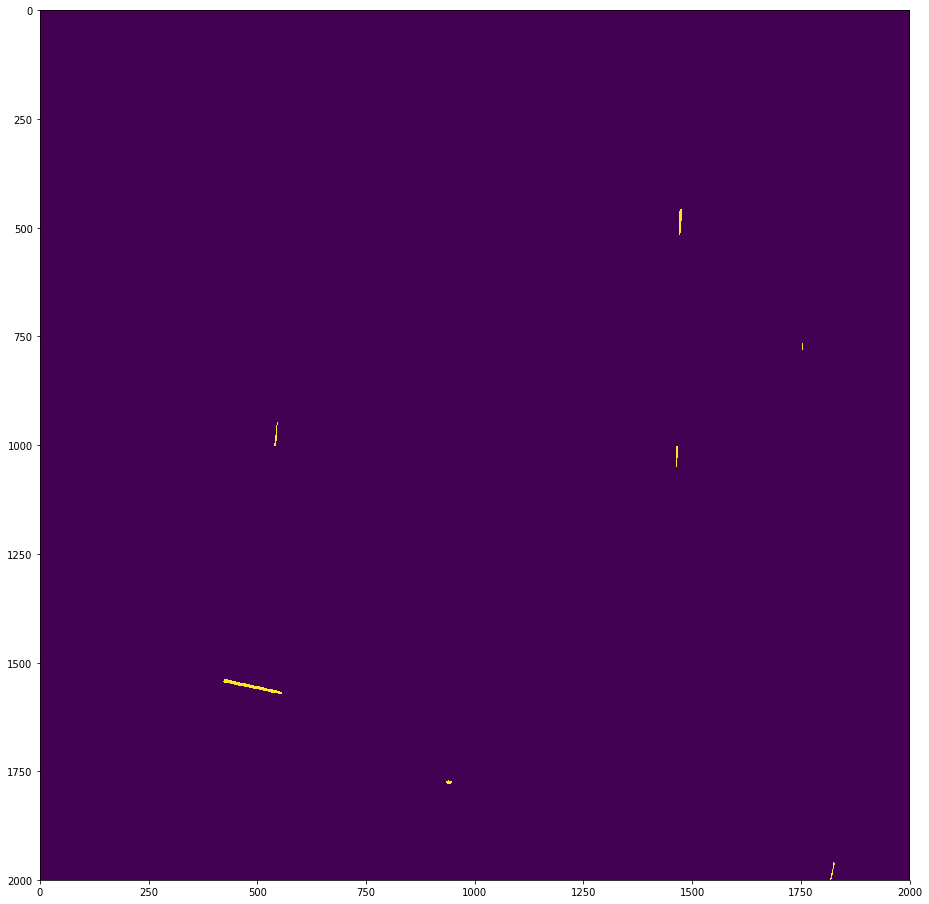

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(b_mask.squeeze()[:2000, :2000])
plt.show()